# Cleveland Heart Disease Binary Classification

# Introduction

One of the leading causes of death within Canada and globally is heart disease (Finegold et al., 2013). Heart disease comprises a range of multifaceted conditions including heart failure and artery blockage (Sun et al., 2015). These conditions can be influenced by a myriad of factors such as genetics and lifestyle (Blue et al., 2012). In this project, we used binary classification (present or absent) to answer the question: What is the risk of heart disease based on the analysis of three key attributes - maximum heart rate achieved, age, and ST-wave depression induced by exercise?

We chose these three variables for the following reasons. Higher maximum heart rates could possibly indicate better cardiovascular fitness. Age is a well-studied risk factor for heart disease; showing that the risk of heart disease occurrence increases with age. Lastly, the degree of ST-wave depression induced by exercise relative to rest is associated with a greater likelihood of heart disease as it reaches higher levels. 

By investigating the relationship between these variables and the presence of heart disease, we created a predictive model that can effectively identify individuals at risk of heart disease. This classification was conducted on the Cleveland heart disease data set which contains 303 entries across 14 different variables.

# Methods

In [1]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
library(dplyr)
#install.packages("kknn")
library(kknn)
library(ggplot2)
#install.packages("cowplot")
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Cleveland data set on heart disease was retrieved from the UCI machine learning repository. Data set was cleaned and wrangled to ensure the data is in a suitable format for further processing. Column 14 (Target) was renamed to “Diseased” to clarify if heart disease is present or absent in the diagonsis.

In [2]:
#Reading dataset, includes column renaming
set.seed(29)
file_path <- "https://github.com/colemantatiana/dsci-100-2023w1-group-29/raw/main/heart.csv"
heart_data <- read_delim(file_path, col_names = TRUE)

#Conversion of "target" to factor
heart_data <- mutate(heart_data, target = as.factor(target))

#Renaming
colnames(heart_data)[14] = "diseased"
    heart_data |> distinct(diseased)

# Check for missing values.
missing <- heart_data |> 
  summarise(across(everything(), ~ sum(is.na(.x))))
missing 
#No missing data 

# Overview of the data
glimpse(heart_data)
summary(heart_data)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


diseased
<fct>
1
0


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diseased
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0


Rows: 303
Columns: 14
$ age      <dbl> 63, 37, 41, 56, 57, 57, 56, 44, 52, 57, 54, 48, 49, 64, 58, 5…
$ sex      <dbl> 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1…
$ cp       <dbl> 3, 2, 1, 1, 0, 0, 1, 1, 2, 2, 0, 2, 1, 3, 3, 2, 2, 3, 0, 3, 0…
$ trestbps <dbl> 145, 130, 130, 120, 120, 140, 140, 120, 172, 150, 140, 130, 1…
$ chol     <dbl> 233, 250, 204, 236, 354, 192, 294, 263, 199, 168, 239, 275, 2…
$ fbs      <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0…
$ restecg  <dbl> 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1…
$ thalach  <dbl> 150, 187, 172, 178, 163, 148, 153, 173, 162, 174, 160, 139, 1…
$ exang    <dbl> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0…
$ oldpeak  <dbl> 2.3, 3.5, 1.4, 0.8, 0.6, 0.4, 1.3, 0.0, 0.5, 1.6, 1.2, 0.2, 0…
$ slope    <dbl> 0, 0, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 1…
$ ca       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0…
$ thal     <dbl> 1

      age             sex               cp           trestbps    
 Min.   :29.00   Min.   :0.0000   Min.   :0.000   Min.   : 94.0  
 1st Qu.:47.50   1st Qu.:0.0000   1st Qu.:0.000   1st Qu.:120.0  
 Median :55.00   Median :1.0000   Median :1.000   Median :130.0  
 Mean   :54.37   Mean   :0.6832   Mean   :0.967   Mean   :131.6  
 3rd Qu.:61.00   3rd Qu.:1.0000   3rd Qu.:2.000   3rd Qu.:140.0  
 Max.   :77.00   Max.   :1.0000   Max.   :3.000   Max.   :200.0  
      chol            fbs            restecg          thalach     
 Min.   :126.0   Min.   :0.0000   Min.   :0.0000   Min.   : 71.0  
 1st Qu.:211.0   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:133.5  
 Median :240.0   Median :0.0000   Median :1.0000   Median :153.0  
 Mean   :246.3   Mean   :0.1485   Mean   :0.5281   Mean   :149.6  
 3rd Qu.:274.5   3rd Qu.:0.0000   3rd Qu.:1.0000   3rd Qu.:166.0  
 Max.   :564.0   Max.   :1.0000   Max.   :2.0000   Max.   :202.0  
     exang           oldpeak         slope             ca        
 Mi

Forward selection is performed below. Data was split into a training set and test set, using only the training set to pick the predictors. From the training data, we identified three relevant predictors for our analysis: (1) thalach (maximum heart rate achieved) (2) age, and (3) old peak (ST-wave depression induced by exercise). 

In [11]:
# Create training (75%) and testing (25%) data split 
heart_split <- initial_split(heart_data, prop = 0.75, strata = diseased)  
heart_train <- training(heart_split)   
heart_test <- testing(heart_split)

# View training and testing sets
glimpse(heart_train)
glimpse(heart_test)

names <- colnames(heart_train |> select(age,trestbps, chol, thalach, oldpeak))

accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

heart_vfold <- vfold_cv(heart_train, v = 5, strata = diseased)

#for loop to test potential predictors 
n_total <- length(names)
selected <- c()
for (i in 1:n_total) {
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        preds_new <- c(selected, names[[j]])
        model_string <- paste("diseased", "~", paste(preds_new, collapse="+"))
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_train) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())
acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

Rows: 226
Columns: 14
$ age      <dbl> 67, 62, 63, 53, 48, 58, 58, 60, 40, 60, 64, 43, 57, 55, 65, 5…
$ sex      <dbl> 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1…
$ cp       <dbl> 0, 0, 0, 0, 1, 1, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0…
$ trestbps <dbl> 160, 140, 130, 140, 110, 120, 132, 130, 110, 117, 140, 120, 1…
$ chol     <dbl> 286, 268, 254, 203, 229, 284, 224, 206, 167, 230, 335, 177, 2…
$ fbs      <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ restecg  <dbl> 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0…
$ thalach  <dbl> 108, 160, 147, 155, 168, 160, 173, 132, 114, 160, 158, 120, 1…
$ exang    <dbl> 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1…
$ oldpeak  <dbl> 1.5, 3.6, 1.4, 3.1, 1.0, 1.8, 3.2, 2.4, 2.0, 1.4, 0.0, 2.5, 0…
$ slope    <dbl> 1, 0, 1, 0, 0, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1…
$ ca       <dbl> 3, 2, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 1, 3, 1, 0, 1, 0, 0, 3…
$ thal     <dbl> 2

size,model_string,accuracy
<int>,<chr>,<dbl>
1,diseased ~ thalach,0.6596838
2,diseased ~ thalach+oldpeak,0.7351779
3,diseased ~ thalach+oldpeak+trestbps,0.7347826
4,diseased ~ thalach+oldpeak+trestbps+age,0.7128458
5,diseased ~ thalach+oldpeak+trestbps+age+chol,0.7041502


For our initial visualization (Figure 1), we used 2 scatter plots to show two of our predictor variables as a function of the third: age. 

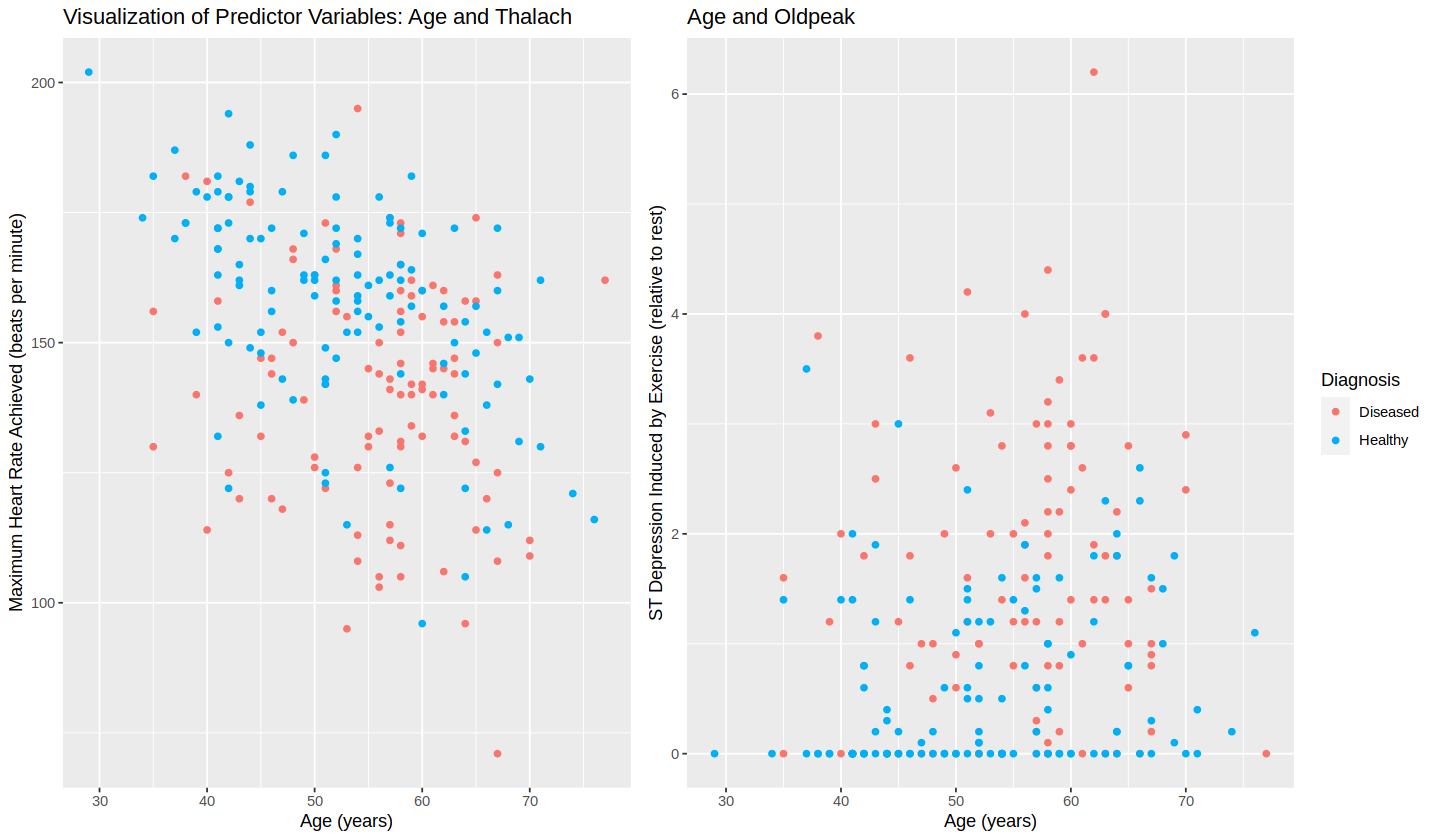

In [17]:
# EDA was conduct upon all 3 variables 
heart_plot1 <- heart_train |>
  ggplot(aes(x = age, 
             y = thalach, 
             colour = diseased)) +
  labs(x = "Age (years)", y = "Maximum Heart Rate Achieved (beats per minute)") +
  theme(legend.position = "none") +
  geom_point() +
  ggtitle("Visualization of Predictor Variables: Age and Thalach") +
  scale_color_manual(values = c("#f8766d", "#00b0f6"))

heart_plot2 <- heart_train |> ggplot(aes(x = age, y = oldpeak, colour = diseased)) + 
    geom_point() + 
    ggtitle("Age and Oldpeak") + 
    labs(x = "Age (years)", y = "ST Depression Induced by Exercise (relative to rest)", colour = "Diagnosis") +
    scale_color_manual(labels = c("Diseased", "Healthy"), values = c("#f8766d", "#00b0f6"))

options(repr.plot.height = 7, repr.plot.width = 12)
# Install and load the cowplot package already in the very beginning
# install.packages("cowplot")
library(cowplot)

heart_plots <- plot_grid(heart_plot1, heart_plot2,
                         ncol = 2, nrow = 1, 
                         rel_widths = c(4, 5))

heart_plots

**Figure 1. Scatter plots to visualize our predictor variables: Age and Thalach, Age and Oldpeak**

In order to improve our classifier, a value was chosen for the number of neighbors, K. The best number of neighbors was decided by using cross-validation to calculate the accuracy for each value of K, and then the value of K with the best accuracy was picked. Accuracy versus K was plotted as shown in Figure 2. below. K= 21 provides the highest accuracy and was therefore selected. 

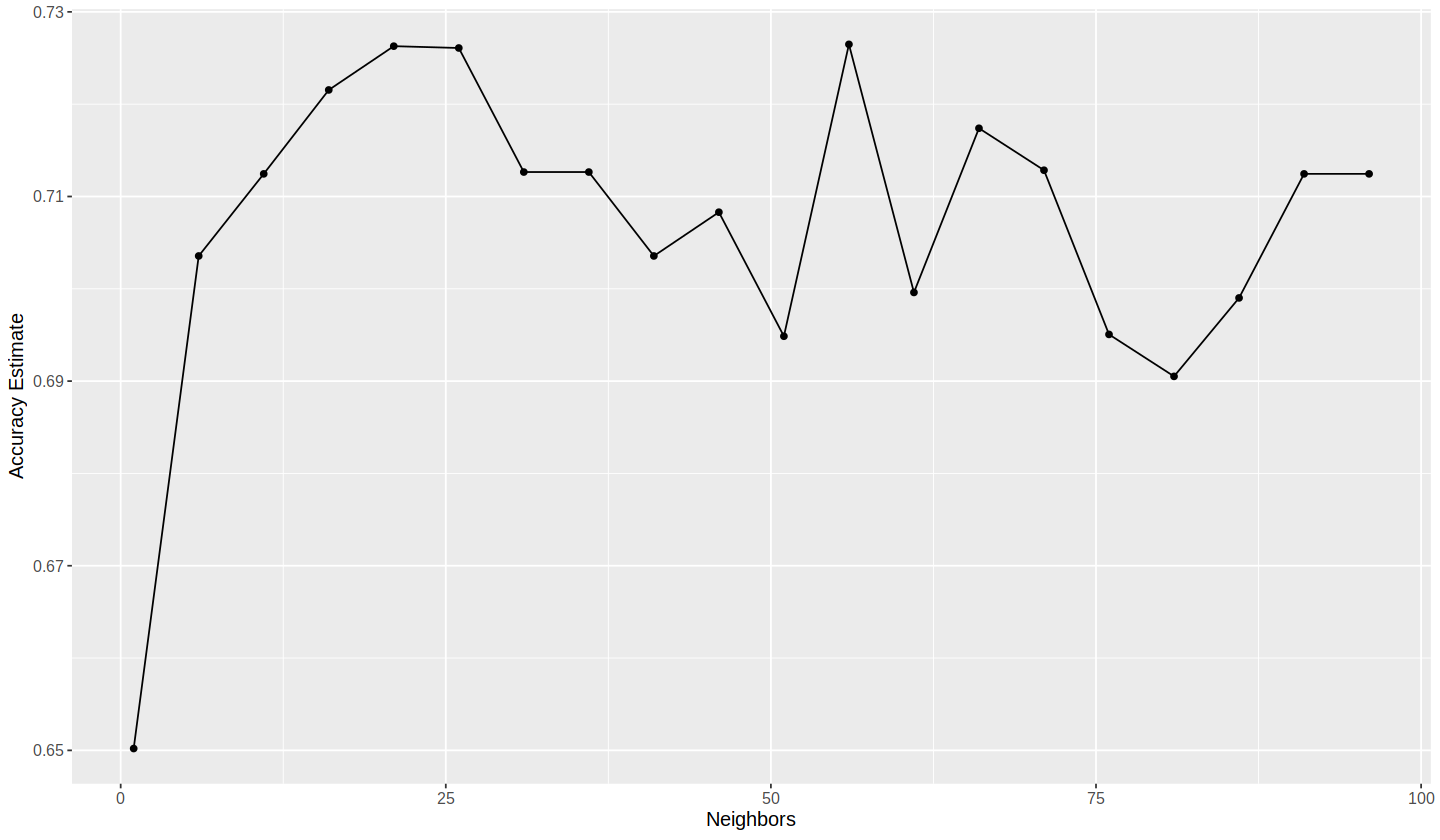

In [5]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

k_accuracies <- knn_results |>
  filter(.metric == "accuracy")

#Accuracy vs K plot generated
accuracy_vs_k <- ggplot(k_accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k

**Figure 2. Number of Neighbors vs. Accuracy Estimate**

We now place these steps in a workflow using the functions add_recipe and add_model. We then use the fit function to run the whole workflow on the unscaled_cancer data.  

In [18]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
  set_engine("kknn") |>
  set_mode("classification")

heart_recipe <- recipe(diseased ~ thalach+oldpeak+age, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2920354
Best kernel: rectangular
Best k: 21

The performance of our model was prepared to be evaluated by creating the train/test split, preprocessing the data, and training the classifier. Here we predict the labels in the test set and assess the classifier’s performance by examining accuracy (using the metrics function). Looking at the .estimate variable, the estimated accuracy of the classifier on the test data was 73%. 

In [7]:
heart_test_predictions <- predict(knn_fit, heart_test) |>
  bind_cols(heart_test)
heart_test_predictions

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diseased
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
1,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
1,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
1,49,1,1,130,266,0,1,171,0,0.6,2,0,2,1
1,44,1,2,130,233,0,1,179,1,0.4,2,0,2,1
1,61,1,2,150,243,1,1,137,1,1.0,1,0,2,1
1,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
1,39,1,2,140,321,0,0,182,0,0.0,2,0,2,1
1,44,1,2,140,235,0,0,180,0,0.0,2,0,2,1


In [8]:
heart_test_predictions |>
  metrics(truth = diseased, estimate = .pred_class) |>
  filter(.metric == "accuracy")
heart_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7272727


.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diseased
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
1,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
1,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
1,49,1,1,130,266,0,1,171,0,0.6,2,0,2,1
1,44,1,2,130,233,0,1,179,1,0.4,2,0,2,1
1,61,1,2,150,243,1,1,137,1,1.0,1,0,2,1
1,53,1,2,130,197,1,0,152,0,1.2,0,0,2,1
1,39,1,2,140,321,0,0,182,0,0.0,2,0,2,1
1,44,1,2,140,235,0,0,180,0,0.0,2,0,2,1


Confusion matrix was generated to calculate precision and recall. Recall is 92.86%. Precision is 68.42%. 

In [9]:
confusion <- heart_test_predictions |>
             conf_mat(truth = diseased, estimate = .pred_class)
confusion

          Truth
Prediction  0  1
         0 17  3
         1 18 39

The confusion matrix for the classifier is then analyzed, showing the table of predicted labels and correct labels. The matrix shows 17 observations correctly classified as absent, and 39 were correctly classified as present. Some classifier mistakes are shown, classifying 18 observations as present when truly absent and 3 observations as absent when truly present. 

(1= present 0 = absent)

Now we look at the proportion of when heart disease is present versus when heart disease is absent observations in the training data.  This will help us take a look at the majority classifier. The “present” data is the majority although the number of observations is quite similar. We would not have to worry as much that the majority classifier would always predict that a new observation is “present.”

In [10]:
heart_proportions <- heart_train |>
                      group_by(diseased) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_train))
heart_proportions

diseased,n,percent
<fct>,<int>,<dbl>
0,103,45.57522
1,123,54.42478


We used scatter plots as a primary technique to visualize our results. Within the plots, we used both color and shape to distinguish between individuals with or without heart disease.

In [20]:
code:

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: code:
   ^


In [ ]:
<< Figure caption >>

Additionally, we used background colors to indicate the diagnosis of our model. 

In [21]:
code:

ERROR: Error in parse(text = x, srcfile = src): <text>:2:0: unexpected end of input
1: code:
   ^


In [ ]:
<< Figure caption >>

# Results

**Results sections do not discuss what the results mean! Only what the results are!**

We found linear or non-linear separations between clusters of data points, as well as any outliers or data points that do not conform to general trends/patterns.

# Discussion

https://datasciencebook.ca/classification2.html#critically-analyze-performance
^ Used this section in particular

In [25]:
#Code to look at proportions 
heart_proportions <- heart_train |>
                      group_by(diseased) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_train))
heart_proportions

diseased,n,percent
<fct>,<int>,<dbl>
0,103,45.57522
1,123,54.42478


In our project, we used binary classification to establish the presence or absence of heart disease based on three key attributes: maximum heart rate achieved, age, and ST-wave depression induced by exercise. Using the Cleveland heart disease data set with 303 entries across 14 variables, our predictive model examined the relationship between these factors, aiming to identify individuals at risk of heart disease.

After creating our model, we analyzed the classifier's performance by examining accuracy (using the metrics function). Looking at the estimated variable, the estimated accuracy of the classifier on the test data was 73%. We also took a look at the confusion matrix for the classifier which showed 17 observations correctly classified as absent, and 39 correctly classified as present. Some classifier mistakes are shown, classifying 18 observations as present when truly absent and 3 observations as absent when truly present. Additionally, we looked at the proportion of when heart disease is present versus when heart disease is absent observations in the training data. This will help us recognize the majority classifier. The “heart disease present” data is the majority although the number of observations is quite similar. We would not have to worry as much that the majority classifier would always predict that a new observation is “present.” Upon calculation, our classifier has an accuracy of 73%, precision of 68%, and recall of 93%. 

In the context of our project, certain metrics may have different importance. High recall is often crucial in medical diagnosis. High recall is often essential because it means the model is capturing a large proportion of the actual positive cases. Mis-diagnosing a true positive (diseased) in a medical context like heart disease may have serious consequences. Therefore, our model's recall of 93% is acceptable. The model’s precision of 68% is moderate and indicates the model can avoid false positives, however, there is room for improvement. Further, our dataset carries more “heart disease present” observations and is imbalanced which means that accuracy by itself should not be the only indicator of the model’s performance. 

These findings may hold implications for early identification and intervention in individuals at risk of heart disease. Our predictive model, based on maximum heart rate, age, and ST wave depression, may offer a beneficial tool for healthcare workers assessing cardiovascular health. Identifying individuals at risk allows practitioners to create targeted interventions and preventative measures. Models like this may also allow for optimizing healthcare resources by focusing preventative efforts on individuals at higher risk. This type of management and early intervention can contribute to a more efficient healthcare system as risk assessment processes can be streamlined and decision-making interventions can be expedited. 

Future refinement and addition to the model could involve incorporating additional variables into the model such as lifestyle or genetic factors. Additionally, interactions between existing variables can be explored more in-depth. Additionally, it would also help to assess this model’s performance across a more diverse demographic group. This would enhance the model’s generalizability and robustness and be more applicable across varied healthcare settings.


# References

Blue, G. M., Kirk, E. P., Sholler, G. F., Harvey, R. P., & Winlaw, D. S. (2012). Congenital heart disease: Current knowledge about causes and inheritance. *Medical Journal of Australia, 197*(3). [Read Article](https://www.mja.com.au/journal/2012/197/3/congenital-heart-disease-current-knowledge-about-causes-and-inheritance)

Finegold, J. A., Asaria, P., & Francis, D. P. (2013). Mortality from ischaemic heart disease by country, region, and age: Statistics from World Health Organisation and United Nations. *International Journal of Cardiology, 168*(2), 934–945. [DOI: 10.1016/j.ijcard.2012.10.046](https://doi.org/10.1016/j.ijcard.2012.10.046)

Sun, R., Liu, M., Lu, L., Zheng, Y., & Zhang, P. (2015). Congenital Heart Disease: Causes, Diagnosis, Symptoms, and Treatments. *Cell Biochemistry and Biophysics, 72*(3), 857–860. [DOI: 10.1007/s12013-015-0551-6](https://doi.org/10.1007/s12013-015-0551-6)

Peng, T. T., Trevor Campbell, and Melissa Lee Foreword by Roger. (2023). *Data Science*. In [datasciencebook.ca](https://datasciencebook.ca/). [CC BY-NC-SA 4.0 License](https://creativecommons.org/licenses/by-nc-sa/4.0/). [Read Online](https://datasciencebook.ca/index.html)

UCI Machine Learning Repository. (n.d.). [Archive.ics.uci.edu](https://archive.ics.uci.edu/dataset/45/heart+disease).
